# MNIST UMAP Plots

This notebook contains code to create a plot similar to Figure 3 in the paper.

In [1]:
import os

# We want to be in the project's root directory, not the "notebooks" directory.
os.chdir("..")

In [2]:
import pickle
import json

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from umap import UMAP
from tensorflow.keras.datasets import mnist

from posterior_matching.models.vae import PosteriorMatchingVAE

In [3]:
(_, _), (data_x, data_y) = mnist.load_data()
data_x = np.expand_dims(data_x / 255.0, -1)

In the cell below, set `RUN_DIR` to a directory created by running the `train_pm_vae.py` script with `configs/pm_vae_mnist.py` as the config file.

In [4]:
RUN_DIR = "runs/pm-vae-mnist-20220305-172651"

with open(os.path.join(RUN_DIR, "train_state.pkl"), "rb") as fp:
    model_state = pickle.load(fp)
    
with open(os.path.join(RUN_DIR, "model_config.json"), "r") as fp:
    model_config = json.load(fp)

In [5]:
NUM_SAMPLES = 500

def get_latent_code(x):
    model = PosteriorMatchingVAE.from_config(model_config)
    return model.encoder(x).mean()

def get_samples(x, b):
    model = PosteriorMatchingVAE.from_config(model_config)
    x_o_b = jnp.expand_dims(jnp.concatenate([x * b, b], axis=-1), 0)
    posterior = model.partial_encoder(x_o_b)
    z = posterior.sample(seed=hk.next_rng_key(), sample_shape=NUM_SAMPLES)
    z = jnp.squeeze(z, 1)
    rec = model.decoder(z).mean()
    rec = jnp.where(jnp.expand_dims(b, 0) == 1, jnp.expand_dims(x, 0), rec)
    return z, rec

get_latent_code = jax.jit(hk.transform_with_state(get_latent_code).apply)
get_samples = jax.jit(hk.transform_with_state(get_samples).apply)

## Fit UMAP Model

First, we obtain the VAE's latent codes for the data, then fit a UMAP model to those codes in order to project them to two dimensions.

In [6]:
prng = hk.PRNGSequence(91)

In [7]:
codes = []

for i in range(0, len(data_x), 32):
    z, _ = get_latent_code(model_state.params, model_state.state, prng.next(), data_x[i : i + 32])
    codes.append(z)
    
codes = np.vstack(codes)

In [8]:
umap = UMAP()
umap_codes = umap.fit_transform(codes)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Generate Plot Data

Now, we generate latent codes from $q(\mathbf{z} \mid \mathbf{x}_o)$ for a few example instances and masks. These codes are also projected into the two-dimensional UMAP space for plotting.

In [9]:
mask1 = np.zeros_like(data_x[0])

(z1, rec1), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[0], mask1)

example0 = dict(
    mask1=mask1,
    umap1=umap.transform(z1),
    rec1=rec1,
)

In [10]:
mask1 = np.zeros_like(data_x[2401])
mask1[21:, :] = 1

mask2 = np.zeros_like(data_x[2401])
mask2[17:, :] = 1

mask3 = np.zeros_like(data_x[2401])
mask3[:9, :] = 1

(z1, rec1), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[2401], mask1)
(z2, rec2), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[2401], mask2)
(z3, rec3), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[2401], mask3)

example1 = dict(
    truth=data_x[2401],
    mask1=mask1,
    mask2=mask2,
    mask3=mask3,
    umap1=umap.transform(z1),
    umap2=umap.transform(z2),
    umap3=umap.transform(z3),
    rec1=rec1,
    rec2=rec2,
    rec3=rec3,
)

In [11]:
mask1 = np.zeros_like(data_x[6450])
mask1[:, 19:] = 1

mask2 = np.zeros_like(data_x[6450])
mask2[:, 16:] = 1

mask3 = np.zeros_like(data_x[6450])
mask3[:, 10:] = 1

(z1, rec1), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[6450], mask1)
(z2, rec2), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[6450], mask2)
(z3, rec3), _ = get_samples(model_state.params, model_state.state, prng.next(), data_x[6450], mask3)

example2 = dict(
    truth=data_x[6450],
    mask1=mask1,
    mask2=mask2,
    mask3=mask3,
    umap1=umap.transform(z1),
    umap2=umap.transform(z2),
    umap3=umap.transform(z3),
    rec1=rec1,
    rec2=rec2,
    rec3=rec3,
)

## Making the Plot

Finally, the data we generated above is compiled into a plot.

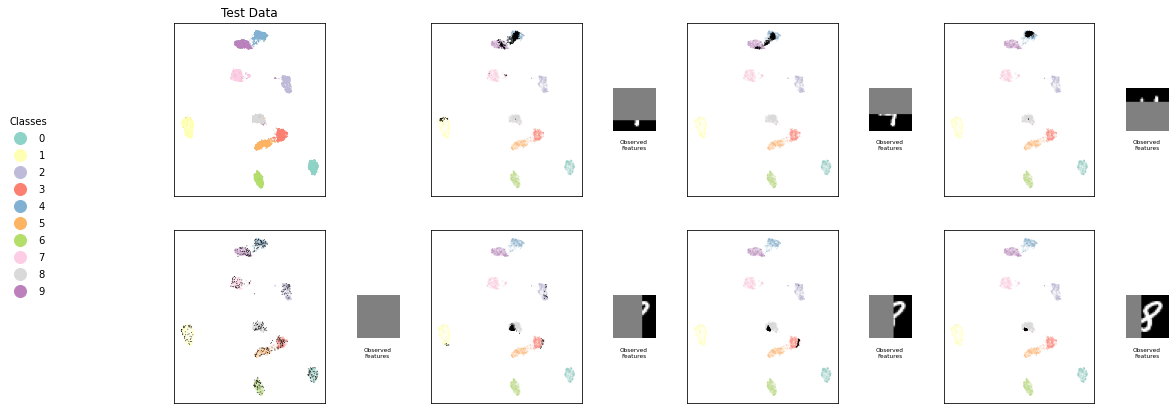

In [12]:
fig, axes = plt.subplots(2, 8, figsize=(18, 7), gridspec_kw={'height_ratios': [4, 4], 'width_ratios': [4, 1, 4, 1, 4, 1, 4, 1]}, squeeze=True)

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']
scatter_size = 3

scatter = axes[0][0].scatter(umap_codes[:, 0], umap_codes[:, 1], marker=".", edgecolors='none', s=scatter_size, c=data_y, cmap=mpc.ListedColormap(colors), rasterized=True)
axes[0][0].set_title("Test Data")

for i in [0, 1]:
    for j in [0, 2, 4, 6]:
        axes[i][j].scatter(umap_codes[:, 0], umap_codes[:, 1], marker=".", edgecolors='none', s=scatter_size, c=data_y, cmap=mpc.ListedColormap(colors), alpha=0.15, rasterized=True)

axes[1][0].scatter(example0["umap1"][:, 0], example0["umap1"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[1][1].imshow(np.ones_like(example2["mask1"]) / 2, cmap="gray", vmin=0, vmax=1)

axes[0][2].scatter(example1["umap1"][:, 0], example1["umap1"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[0][4].scatter(example1["umap2"][:, 0], example1["umap2"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[0][6].scatter(example1["umap3"][:, 0], example1["umap3"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[0][3].imshow(np.where(example1["mask1"] == 1, example1["truth"], 0.5), cmap="gray")
axes[0][5].imshow(np.where(example1["mask2"] == 1, example1["truth"], 0.5), cmap="gray")
axes[0][7].imshow(np.where(example1["mask3"] == 1, example1["truth"], 0.5), cmap="gray")


axes[1][2].scatter(example2["umap1"][:, 0], example2["umap1"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[1][4].scatter(example2["umap2"][:, 0], example2["umap2"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[1][6].scatter(example2["umap3"][:, 0], example2["umap3"][:, 1], marker=".", edgecolors='none', s=scatter_size, c="k", rasterized=True)
axes[1][3].imshow(np.where(example2["mask1"] == 1, example2["truth"], 0.5), cmap="gray")
axes[1][5].imshow(np.where(example2["mask2"] == 1, example2["truth"], 0.5), cmap="gray")
axes[1][7].imshow(np.where(example2["mask3"] == 1, example2["truth"], 0.5), cmap="gray")


fig.legend(
    *scatter.legend_elements(),
    loc="center left",
    title="Classes",
    ncol=1,
    frameon=False,
    markerscale=2.,
)

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    
for ax in [axes[0][2], axes[0][4], axes[0][6], axes[1][0], axes[1][2], axes[1][4], axes[1][6]]:
    ax.sharex(axes[0][0])
    ax.sharey(axes[0][0])
    
for i in [0, 1]:
    for j in [1, 3, 5, 7]:
        axes[i][j].axis("off")
        
axes[0][1].axis("off")

for ax in [axes[1][1], axes[0][3], axes[0][5], axes[0][7], axes[1][3], axes[1][5], axes[1][7]]:
    ax.text(13, 40, "Observed\nFeatures", fontsize="xx-small", horizontalalignment="center")

plt.show()